<a href="https://colab.research.google.com/github/chetan-parthiban/Conceptors/blob/master/ConceptorsIntro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Conceptors More Intuitively
This notebook contains a short coded implementation of a conceptor as well as a walkthrough to help better understand the intuition behind these operations. Note: Use the Colab Light Theme to read plot axes easier <br>
More on conceptors can be found here: <br>
<https://arxiv.org/pdf/1403.3369.pdf>  <br>
<https://arxiv.org/pdf/1406.2671.pdf>

In [0]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse as ellipse
from sklearn.datasets import make_spd_matrix as random_semipositivedefinite
%matplotlib inline

In [0]:
# An implementation of conceptors under the assumption that each dimension is of
# zero mean. A different implementation could be put together without this
# assumption, but a different correlation matrix would have to be computed. 
# Conceptors can be computed: R*(R + alpha*I)'(Note we use ' to denote inverse)
# where R denotes the correlation matrix for our data
def get_conceptor(x, alpha):
    k = x.shape[1] - 1
    means = np.mean(x, axis = 1)
    std = np.sqrt(np.var(x, axis = 1))
    x = (x - means[:,None])/std[:,None]
    corr = (x @ x.T)*(1/k)
    return corr @ inv(corr + (1/alpha**2)*np.eye(x.shape[0]))

# Function to convert an array of eigenvalues and eigenvectors to their 
# corresponding matrix. Simply computes M = SDS' where S and S' are the
# change of basis matrices from standard basis to the eigenvectors and
# vice versa. D is just a diagonal matrix with the eigenvalues. 
def eigToMat(eig,vec):
    D = np.diag(eig)
    return np.matmul(vec,np.matmul(D,inv(vec)))

# Function to get the negated conceptor of a data set
def get_negated(x,alpha):
    conceptor = get_conceptor(x,alpha)
    return np.identity(conceptor.shape[0]) - conceptor

def OR(x,y):
    #nothing
    return x
def AND(x,y):
    #nothing
    return x

# Ellipsoid Clouds to Capture Patterns in Data

---

Consider a set of N points X<sub>j</sub> in R <sup>M</sup>. When we compute the correlation matrix of this set of points, we end up with a matrix that represents degree of variance of the data in different directions. This correlation matrix can also be understood to be representing a M dimensional ellipsoid with axes defined by the eigenvalues and eigenvectors of the matrix. We can think of this ellipsoid as capturing the "pattern" in our data points.

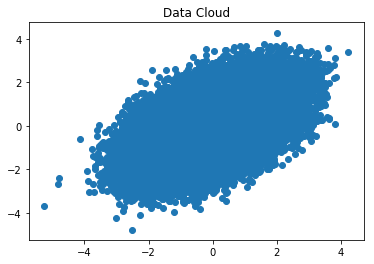



Correlation Matrix
[[1.00001069 0.50015419]
 [0.50015419 1.00076718]]


Singular Values
[0.50023461 1.50054327]


Singular Vectors
[[-0.70737411 -0.70683935]
 [ 0.70683935 -0.70737411]]




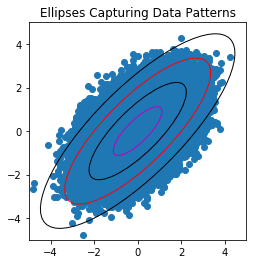

In [5]:
# First lets create a cloud of data points. We will us 2 dimensions for easier
# visualizations of our data
N = 100000
M = 2
x = np.random.multivariate_normal([0,0],[[1,0.5],[0.5,1]],N).T
plt.title('Data Cloud')
plt.scatter(x[0],x[1])
plt.show()
print("\n")

# Since the data is of mean 0 in both dimensions, the correlation matrix is
# simply 1/N*X*X.T
corr = np.matmul(x,x.T)*(1/x.shape[1])
print("Correlation Matrix")
print(corr)
print("\n")

# We can then compute the eigenvalues and eigenvectors of this matrix
eig,vec = np.linalg.eig(corr)
print("Singular Values")
print(eig)
print("\n")
print("Singular Vectors")
print(vec)
print("\n")

# We can then compute the corresponding ellipses for this matrix and plot it. 
# Here we plot several ellipses with the same principal dirrections and centers,
# however, we allow them to scale by multiples of the eigenvalues of the 
# correlation matrix that we previously computed. Notice how the ellipses capture
# the directions and relative magnitudes of variation in the data
theta = np.arccos(np.dot(vec[:,0],[1,0]))
ax = plt.subplot(111, aspect = 'equal')
plt.title('Ellipses Capturing Data Patterns')
ax.scatter(x[0],x[1])
for i in range(4):
    if i ==0:
        c = 'm'
    elif i%2 == 0:
        c = 'r'
    else:
        c = 'k'
    ell = ellipse((0,0), (i+1)*2*eig[0], (i+1)*2*eig[1], np.rad2deg(theta), edgecolor = c, facecolor = 'none')
    ax.add_artist(ell)
plt.xlim((-5,5))
plt.ylim((-5,5))
plt.show()

# From Ellipses to Conceptors
These Ellipses allow us to capture a general pattern in the data in a convenient matrix representation. However, we may want to normalize our eigenvalues so that they lie in some bounded area, for example the unit sphere. Conceptors take on precisely this approach and the conceptor matrix is simply the matrix with the same eigenvectors as our correlation matrix, but with eigenvalues rescaled in a special manner. We rescale them so sigma<sub>new</sub> = sigma<sub>old</sub>/(sigma<sub>old</sub> + alpha) where alpha is a constant that we call the aperture. 

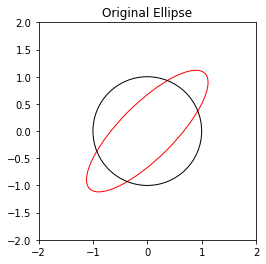

Original Singular Values
[0.50023461 1.50054327]


Modified Singular Values
[0.33343759 0.6000869 ]


Conceptor Matrix
[[0.46666142 0.13332462]
 [0.13332462 0.46686307]]




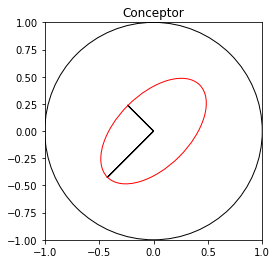

In [6]:
# Notice that our original Ellipse does not lie within the unit circle
theta = np.arccos(np.dot(vec[:,0],[1,0]))
eig,vec = np.linalg.eig(corr)
ax = plt.subplot(111, aspect = 'equal')
plt.title('Original Ellipse')
ell = ellipse((0,0), 2*eig[0], 2*eig[1], np.rad2deg(theta), edgecolor = 'r', facecolor = 'none')
circ = ellipse((0,0),2,2, edgecolor = 'k', facecolor = 'none')
ax.add_artist(ell)
ax.add_artist(circ)
plt.xlim((-2,2))
plt.ylim((-2,2))
plt.show()

# Now we can simply compute our conceptor matrix from our correlation matrix's
# eigenvalues and eigenvectors
alpha = 1
print("Original Singular Values")
print(eig)
print("\n")
print("Modified Singular Values")
for i in range(eig.size):
    eig[i] = eig[i]/(eig[i]+alpha**(-2))
print(eig)
print("\n")

conceptor = eigToMat(eig,vec)
print("Conceptor Matrix")
print(conceptor)
print("\n")

# We can then visualize the associated ellipse for this conceptor matrix and
# notice that it does indeed lie within the unit circle, as we hoped. Here we
# also visualize the principal axes of the ellipse (eigenvectors of corr)
ax = plt.subplot(111, aspect = 'equal')
plt.title('Conceptor')
ell = ellipse((0,0), 2*eig[0], 2*eig[1], np.rad2deg(theta), edgecolor = 'r', facecolor = 'none')
circ = ellipse((0,0),2,2, edgecolor = 'k', facecolor = 'none')
first = plt.arrow(0,0,eig[0]*vec[0,0],eig[0]*vec[1,0])
second = plt.arrow(0,0,eig[1]*vec[0,1],eig[1]*vec[1,1])
ax.add_artist(first)
ax.add_artist(second)
ax.add_artist(ell)
ax.add_artist(circ)
plt.xlim((-1,1))
plt.ylim((-1,1))
plt.show()

# More Efficient Computation
It turns out that we can compute the conceptor a little more effeciently than this. This is implemented at the start of this notebook as the function get_conceptor(). In this section we will verify that these two methods of computing the conceptor are indeed the same. 

In [9]:
# First we compute the quicker implementation of the conceptor, then we compare
# the matrices from the two different implementations to check that they are
# actually the same as we claim they are. 

newConceptor = get_conceptor(x,alpha)
print('Slow Conceptor Calculation')
print(conceptor)
print("\n")

print('Quick Conceptor Calculation')
print(newConceptor)
print("\n")

Slow Conceptor Calculation
[[0.46666142 0.13332462]
 [0.13332462 0.46686307]]


Quick Conceptor Calculation
[[0.46667457 0.13332154]
 [0.13332154 0.46667457]]




# Conceptors for debiasing
We can use conceptors to debias by removing the trend in the data found by the conceptor. We can do that by computing the negated conceptor then applying this to the data. 

Negated Conceptor
[[ 0.53259024 -0.13290051]
 [-0.13290051  0.53411463]]




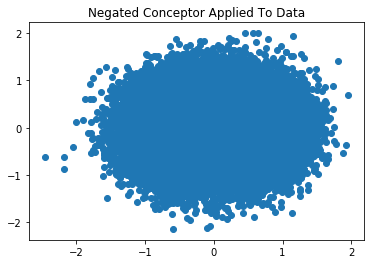



Covariance of transformed data
[[0.23127533 0.00886511]
 [0.00886511 0.23117365]]


In [0]:
# Here we can use the negated conceptor to reduce bias in our original dataset
neg = np.identity(2) - conceptor
print('Negated Conceptor')
print(neg)
print('\n')
negated = np.matmul(np.linalg.matrix_power(neg,1),x)
plt.title('Negated Conceptor Applied To Data')
plt.scatter(negated[0],negated[1])
plt.show()
print('\n')
print('Covariance of transformed data')
print((1/negated.shape[1])*np.matmul(negated,negated.T))

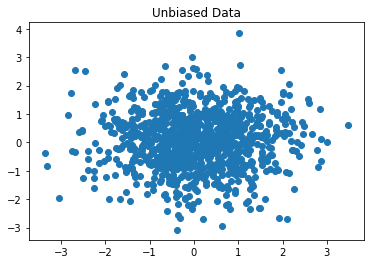

Unbiased Covariance
[[ 1.12059709 -0.00779915]
 [-0.00779915  0.98882662]]




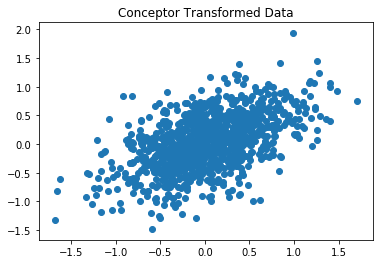

Biased Covariance
[[0.2613152  0.12899886]
 [0.12899886 0.23345081]]


In [0]:
# We can also use the conceptor to introduce bias into an unbiased data set
data = np.random.multivariate_normal([0,0],[[1,0],[0,1]],1000).T
plt.title('Unbiased Data')
plt.scatter(data[0],data[1])
plt.show()
print('Unbiased Covariance')
print((1/1000)*np.matmul(data,data.T))
print('\n')

transformed = np.matmul(conceptor,data)
plt.title('Conceptor Transformed Data')
plt.scatter(transformed[0],transformed[1])
plt.show()
print('Biased Covariance')
print((1/1000)*np.matmul(transformed,transformed.T))

# Higher Dimensions and Alpha
Here we do a quick example of this using a higher dimensional space. We also look closer at the effect of alpha. Manipulating [c,c1,c2,c3] and the linspace for alphas allows for quick tests of how conceptors' effects vary depending on alpha for different matrices

Covariance of multivariate normal
[[ 5.3  1.7  1.4  1.2 -0.1  0.4 -0.6 -3.4  1.9  1.7]
 [ 1.7  1.4  0.6  0.3 -0.1  0.2 -0.3 -1.3  0.8  0.5]
 [ 1.4  0.6  1.1  0.2 -0.1 -0.  -0.3 -1.   0.6  0.6]
 [ 1.2  0.3  0.2  0.9 -0.2  0.1 -0.2 -0.9  0.5  0.3]
 [-0.1 -0.1 -0.1 -0.2  0.6 -0.1 -0.  -0.1 -0.  -0.1]
 [ 0.4  0.2 -0.   0.1 -0.1  0.6 -0.3 -0.4 -0.1  0.3]
 [-0.6 -0.3 -0.3 -0.2 -0.  -0.3  0.6  0.4 -0.3 -0.2]
 [-3.4 -1.3 -1.  -0.9 -0.1 -0.4  0.4  3.1 -1.5 -1.2]
 [ 1.9  0.8  0.6  0.5 -0.  -0.1 -0.3 -1.5  1.3  0.6]
 [ 1.7  0.5  0.6  0.3 -0.1  0.3 -0.2 -1.2  0.6  1.1]]


Absolute value of covariance of negated data at alpha = 1
[[0.2 0.  0.  0.  0.  0.  0.  0.1 0.  0. ]
 [0.  0.2 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.2 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.2 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.2 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.2 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.2 0.  0.  0. ]
 [0.1 0.  0.  0.  0.  0.  0.  0.2 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0

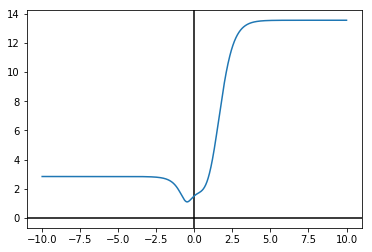

In [0]:
%precision 1
samples = 10000
dim = 10
cov = random_semipositivedefinite(dim)
print('Covariance of multivariate normal')
print(cov)
print('\n')
y = np.random.multivariate_normal(np.zeros(dim),cov,10000).T
neg = get_negated(y,1)
y_hat = np.matmul(neg,y)
print('Absolute value of covariance of negated data at alpha = 1')
print(abs((1/samples)*np.matmul(y_hat,y_hat.T)))
print('\n')

print('Effectiveness of negated conceptor (0 is ideal) for log(alpha)')
alphas = np.linspace(-10,10,1000)
alphas = np.exp(alphas)
z = np.zeros(1000)
for i in range(1000):
    negi = get_negated(y,alphas[i])
    y_hati = np.matmul(negi,y)
    corr = (1/samples)*np.matmul(y_hati,y_hati.T)
    corr = corr * 1/corr[0][0]
    z[i] = np.linalg.norm(np.identity(dim)-corr)
            
alphas = np.log(alphas)
ax = plt.subplot(111)
ax.axvline(c = 'k')
ax.axhline(c = 'k')
ax.plot(alphas,z)
plt.show()